In [31]:
#Paraphrase detection with a classifier using BERT representation
#THis notebook is based on the Microsoft Research paraphrase corpus where a classifier is trained to detect paraphrases

In [32]:
%pip install transformers

In [33]:
import os 
import pandas as pd
import seaborn as sns
import torch.multiprocessing as torch_mp
import torch
from transformers import RobertaTokenizerFast, RobertaModel
from transformers import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import operator
#import optuna

In [34]:
model = RobertaModel.from_pretrained("roberta-base")
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def make_segment_ids(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token == '[SEP]':
            current_id +=1
    return segment_ids

def tokenize(text):
    text = 'CLS' + text + 'SEP'
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    seg = make_segment_ids(tokens)

    return ids, seg

def load_tsv(tsv_text):
    content = dict()
   
    temp1 = []; temp2 = []; temp3 = []; temp4 = []; temp5 = []
    with open(tsv_text, 'r') as tr:
        for line in tr:
            line = line.split('\t')
            temp1.append(line[0])
            temp2.append(line[1])
            temp3.append(line[2])
            temp4.append(line[3])
            temp5.append(line[4])

    content["Quality"] = temp1[1:]; content["#1 ID"] = temp2[1:]; content["#2 ID"] = temp3[1:]
    content["#1 String"] = temp4[1:]; content["#2 String"] = temp5[1:]

    return content

def plot_confusion_matrix(y_preds, y_true, labels):
    """Plotting confusion matrix given predicted y(y_pred), true y(y_true) and labels"""
    cm = confusion_matrix(y_true, y_preds, labels, normalize= True)
    fig,ax = plt.subplots(len(labels), len(labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
    disp.plot(cmap= "Blues", values_format =".2f", ax = ax, colorbar = False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [36]:

#if torch.cuda.is_available() else "cpu")

def out_hidden_states(text,model, flag = "tensor"):

    """Switches between Arrays and Tensors"""
    device = torch.device("cuda")
    input = tokenizer(text, return_tensors ="pt",padding=True, truncation=True)
    ins = {k:v.to(device) for k,v in input.items()}
    model = model.to(device)

    with torch.no_grad():
        out = model(**ins)[-2]

        if flag == "array":
            out = out[:,0].cpu().numpy()[:,:]

        elif flag == "tensor": 
            out = out[:, 0]

        else :
            print("select 'tensor' or 'array' ")

    return out
def accuracy(y_true, y_pred):
    corr = 0
    if len(y_true) == len(y_pred):
        for a,b in zip(y_true, y_pred):
            if a == b:
                corr += 1
            else:
                pass
        print("The Accuracy of this prediction is {}".format(corr/len(y_true)))
    else:
        print("y_true is not the same as y_pred")
        pass
    return corr/len(y_true)

def accuracy_tensor(probs: torch.FloatTensor, targets: torch.LongTensor) -> float:
    """
    Args:
        probs: A float32 tensor of shape ``(batch_size, class_count)`` where each value 
            at index ``i`` in a row represents the score of class ``i``.
        targets: A long tensor of shape ``(batch_size,)`` containing the batch examples'
            labels.
    """
    predicted = probs.argmax(dim=1)
    corrects = (predicted == targets)
    accuracy = corrects.sum().float() / float( targets.size(0) )
    return accuracy


In [37]:
MRPC = "Mrpc"

os.listdir(MRPC)

train = MRPC + '/msr_paraphrase_train.txt'
dev = MRPC + '/msr_paraphrase_dev.tsv'
test = MRPC + '/msr_paraphrase_test.txt'
label2id = {1: "paraphrase", 0: "not paraphrase"}

In [38]:
raw_train = pd.DataFrame(load_tsv(train))
raw_dev = pd.DataFrame(load_tsv(dev))
raw_test = pd.DataFrame(load_tsv(test))

columns = raw_train.columns
print(columns)

Index(['Quality', '#1 ID', '#2 ID', '#1 String', '#2 String'], dtype='object')


(array([1147.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         578.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

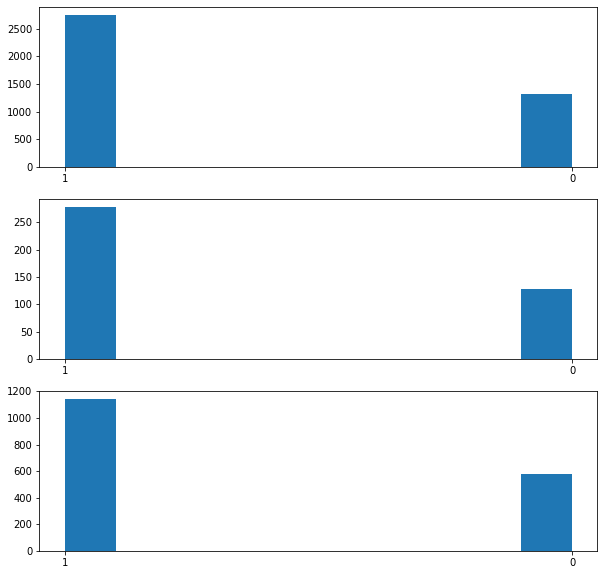

In [39]:
fig,ax = plt.subplots(3, figsize = (10,10))

ax[0].hist(raw_train.Quality)
ax[1].hist(raw_dev.Quality)
ax[2].hist(raw_test.Quality)

In [41]:
raw_train_1 = out_hidden_states(list(raw_train['#1 String']), model)
torch.save(raw_train_1, "raw_ train_1_string.pt")

raw_train_2 = out_hidden_states(list(raw_train['#2 String']), model)
torch.save(raw_train_2, "raw_train_2_string.pt")

raw_dev_1 = out_hidden_states(list(raw_dev['#1 String']), model)
torch.save(raw_dev_1, "raw_dev_1_string.pt")

raw_dev_2 = out_hidden_states(list(raw_dev['#2 String']), model)
torch.save(raw_dev_2, "raw_dev_2_string.pt")

raw_test_1 = out_hidden_states(list(raw_test['#1 String']), model)
torch.save(raw_test_1, "raw_test_1_string.pt")

raw_test_2 = out_hidden_states(list(raw_test['#2 String']), model)
torch.save(raw_test_2, "raw_test_2_string.pt")

In [ ]:
raw_test_1.size(0)
raw_test['sim'] = 0
for i in range(raw_test_1.size(0)):
  assert raw_test_1.size(0) == raw_test_2.size(0)
  temp = torch.cosine_similarity(raw_test_1[i, :], raw_test_2[i, :])
  raw_test.iloc([i,-1]) = temp

In [ ]:
#Obtaining token ids using BERT Tokenizer for train,dev and test split
 
train_1_id, train_1_seg_id = zip(*raw_train["#1 String"].map(tokenize)) #unpacks 
train_2_id, train_2_seg_id= zip(*raw_train["#2 String"].map(tokenize)) 

dev_1_id, dev_1_seg_id = zip(*raw_dev["#1 String"].map(tokenize)) 
dev_2_id, dev_2_seg_id = zip(*raw_dev["#2 String"].map(tokenize)) 

test_1_id, test_1_seg_id = zip(*raw_test["#1 String"].map(tokenize))
test_2_id, test_2_seg_id  = zip(*raw_test["#2 String"].map(tokenize))

#Obtaining labels to be used in classification head
train_labels = raw_train["Quality"]; dev_labels = raw_dev["Quality"]; test_labels = raw_test["Quality"]

In [ ]:
#Checking function per input
out_hidden_states(raw_train['#1 String'][0]).max()

tensor(3.8153)

USING NEURAL LAYER

In [ ]:
train_string_1 = raw_train["#1 String"]
train_string_2 = raw_train['#2 String']

dev_string_1 = raw_dev['#1 String']
dev_string_2 = raw_dev['#2 String']

test_string_1 = raw_test['#1 String']
test_string_2 = raw_test['#2 String']

train_string_1 = [out_hidden_states(text, flag = "tensor") for text in train_string_1]
train_string_1 = torch.cat(train_string_1, dim = 0)

train_string_2 = [out_hidden_states(text, flag = "tensor") for text in train_string_2]
train_string_2 = torch.cat(train_string_2, dim = 0)

dev_string_1 = [out_hidden_states(text, flag = "tensor") for text in dev_string_1]
dev_string_1 = torch.cat(dev_string_1, dim = 0)

dev_string_2 = [out_hidden_states(text, flag = "tensor") for text in dev_string_2]
dev_string_2 = torch.cat(dev_string_2, dim = 0)

test_string_1 = [out_hidden_states(text, flag = "tensor") for text in test_string_1]
test_string_1 = torch.cat(test_string_1, dim = 0)

test_string_2 = [out_hidden_states(text, flag = "tensor") for text in test_string_2]
test_string_2 = torch.cat(test_string_2, dim = 0)

In [ ]:
train = torch.cat((train_string_1, train_string_2), dim = 1)
dev = torch.cat((dev_string_1, dev_string_2), dim = 1)
test  = torch.cat((test_string_1, test_string_2), dim = 1)

In [ ]:
train.shape

torch.Size([4076, 1536])

TRAIN ON TRAIN_SET

In [ ]:
torch.tensor(train_labels)

tensor([1., 0., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

In [ ]:
import torch 
import torch.nn as nn

class pp_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(768*2,2)
        self.dropout = nn.Dropout(p = 0.1, inplace= True)
        
    def forward(self, inputs:torch.tensor):
        x = self.dropout(inputs)
        x = self.l1(inputs)
        return x


In [ ]:
paraphrase_model = pp_model()
paraphrase_model.parameters

<bound method Module.parameters of pp_model(
  (l1): Linear(in_features=1536, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>

Learning Rate - 0.05

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/2402385547.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/2402385547.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)


epoch: 0 train accuracy: 79.88, loss: 0.46679
epoch: 0 valid accuracy: 31.62, loss: 23.12375
epoch: 1 train accuracy: 32.46, loss: 22.83001
epoch: 1 valid accuracy: 32.84, loss: 4.72463
epoch: 2 train accuracy: 34.05, loss: 4.71504
epoch: 2 valid accuracy: 68.38, loss: 6.95443
epoch: 3 train accuracy: 67.54, loss: 6.93530
epoch: 3 valid accuracy: 68.38, loss: 12.37260
epoch: 4 train accuracy: 67.54, loss: 12.50000
epoch: 4 valid accuracy: 68.38, loss: 14.60933
epoch: 5 train accuracy: 67.54, loss: 14.78597
epoch: 5 valid accuracy: 68.38, loss: 14.53509
epoch: 6 train accuracy: 67.54, loss: 14.69101
epoch: 6 valid accuracy: 68.38, loss: 12.70249
epoch: 7 train accuracy: 67.54, loss: 12.78492
epoch: 7 valid accuracy: 68.38, loss: 9.48760
epoch: 8 train accuracy: 67.54, loss: 9.45541
epoch: 8 valid accuracy: 68.14, loss: 5.16421
epoch: 9 train accuracy: 67.79, loss: 4.98828
epoch: 9 valid accuracy: 70.34, loss: 1.60408
epoch: 10 train accuracy: 72.50, loss: 1.55719
epoch: 10 valid accurac

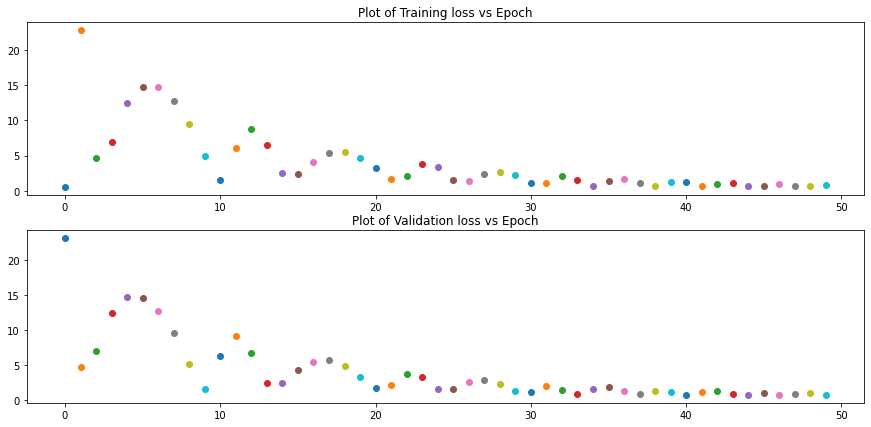

In [ ]:
#Using Adam Optimizer

from torch import optim

train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)

optimizer = optim.AdamW(paraphrase_model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

#For plot
validation_loss = []
epoch_range = range(50)

fig,ax = plt.subplots(2,1, figsize = (15,7), sharey = 'row')

for epoch in epoch_range:

    paraphrase_model.train()
    logits = paraphrase_model.forward(train)
    train_loss = criterion(logits, train_labels)
       
    ax[0].scatter(epoch, train_loss.item())
    ax[0].set_title("Plot of Training loss vs Epoch")

    print("epoch: {} train accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(logits, train_labels) * 100,train_loss.item()))
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    paraphrase_model.eval() 

    valid_logits = paraphrase_model(dev)
    valid_loss = criterion(valid_logits, valid_labels)
    print("epoch: {} valid accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(valid_logits, valid_labels) * 100,valid_loss.item()))

    ax[1].scatter(epoch, valid_loss.item())
    ax[1].set_title("Plot of Validation loss vs Epoch")

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/3731218117.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/3731218117.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)


epoch: 0 train accuracy: 83.49, loss: 0.37999
epoch: 0 valid accuracy: 81.13, loss: 0.43644
epoch: 1 train accuracy: 82.73, loss: 0.38200
epoch: 1 valid accuracy: 79.66, loss: 0.44208
epoch: 2 train accuracy: 81.77, loss: 0.40655
epoch: 2 valid accuracy: 78.19, loss: 0.45429
epoch: 3 train accuracy: 71.34, loss: 0.67329
epoch: 3 valid accuracy: 71.32, loss: 0.75416
epoch: 4 train accuracy: 35.23, loss: 2.16862
epoch: 4 valid accuracy: 34.31, loss: 2.22293
epoch: 5 train accuracy: 67.54, loss: 4.41250
epoch: 5 valid accuracy: 68.38, loss: 4.39819
epoch: 6 train accuracy: 68.06, loss: 1.09559
epoch: 6 valid accuracy: 69.12, loss: 1.17342
epoch: 7 train accuracy: 34.54, loss: 2.39037
epoch: 7 valid accuracy: 33.58, loss: 2.45010
epoch: 8 train accuracy: 67.54, loss: 4.40929
epoch: 8 valid accuracy: 68.38, loss: 4.39787
epoch: 9 train accuracy: 68.25, loss: 1.09511
epoch: 9 valid accuracy: 69.12, loss: 1.17476
epoch: 10 train accuracy: 35.08, loss: 2.31799
epoch: 10 valid accuracy: 33.58, 

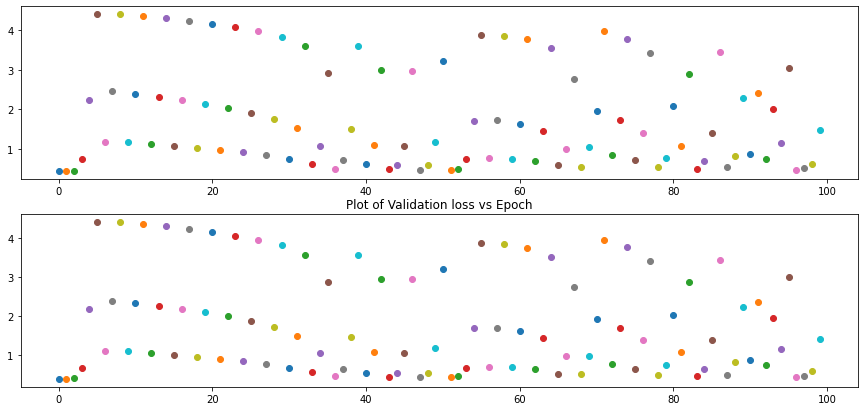

In [ ]:
#Using Adam Optimizer

from torch import optim

train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)

optimizer = optim.SGD(paraphrase_model.parameters(), lr=0.05)

criterion = nn.CrossEntropyLoss()
paraphrase_model.train()

#For plot
validation_loss = []
epoch_range = range(100)

fig,ax = plt.subplots(2,1, figsize = (15,7), sharey = 'row')

for epoch in epoch_range:   

    logits = paraphrase_model.forward(train)
    train_loss = criterion(logits, train_labels)

    valid_logits = paraphrase_model.forward(dev)
    valid_loss = criterion(valid_logits, valid_labels)
       
    ax[1].scatter(epoch, train_loss.item())
    ax[0].scatter(epoch, valid_loss.item())

    plt.title("Plot of Training loss vs Epoch")
    plt.title("Plot of Validation loss vs Epoch")

    print("epoch: {} train accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(logits, train_labels) * 100,train_loss.item()))
    print("epoch: {} valid accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(valid_logits, valid_labels) * 100,valid_loss.item()))
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
